<h1 style="font-size:2.2em; font-weight:bold; text-align:center;">Exploratory Data Analysis</h1>

This project serves as a **Proof of Concept (PoC)** to explore **anomaly scoring** techniques for detecting potentially fraudulent banking transactions.

The data covers the period from **April 2, 2025** to **July 2, 2025**, based on the assumption that in mid-2025, trade tensions lead to increased abnormal or suspicious transaction activities.

For exploratory data analysis (EDA), we will:

- Integrate dynamic currency conversion using the Riksbanken API.

- Explore missing values.

- Conduct descriptive analytics using SQL.

- Perform univariate and bivariate analysis to analyze data distribution and identify outliers.





| **Key Findings**                                                                                 |
|--------------------------------------------------------------------------------------------------|
| Dataset merged from `transaction records`, `KYC customer profiles`, and `summary statistics`. |
| Contains 10,716 transactions with 40 features (31 categorical, 9 numerical).                      |
| Includes 107 duplicate records.                                                                  |
| All amounts in different currencies have been converted to EUR.                                  |
| Missing values are present in some categorical features.                                         |
| Several numerical features contain potential outliers.             |
| Categorical features exhibit a mix of low and high cardinality.     |       





## <h2 style="font-size: 1.6em; font-weight: bold;"> 1. Data Collection </h2>
Import Required Packages and Data

**Importing Pandas, Numpy, Matplotlib, Seaborn, Plotly.express and Warings Library.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Import the CSV Data as Pandas DataFrame**

In [ ]:
#Import data from 3 reports and merge them using a left join on `customer_id`

transaction_df = pd.read_csv('data/transactions.csv')
customer_df = pd.read_csv('data/customers.csv')
sum_statistic_df = pd.read_csv('data/summary_statistics.csv')

df = transaction_df.merge(customer_df, on='customer_id', how='left') \
                   .merge(sum_statistic_df, on='customer_id', how='left')

Handle duplicate columns after merging.

In [3]:
dup_cols = []
cols = df.columns.tolist()

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df[cols[i]].equals(df[cols[j]]):
            dup_cols.append((cols[i], cols[j]))
print("Columns with identical values:")
for c1, c2 in dup_cols:
    print(f"{c1} and {c2}")
    
dropped = set()
kept = set()

for c1, c2 in dup_cols:
    if c2 not in dropped:
        df.drop(columns=c2, inplace=True)
        dropped.add(c2)
        kept.add(c1)     
print("Dropped columns:", list(dropped))
print ("Remaining columns:", list(kept) )

Columns with identical values:
currency_x and currency_y
currency_x and currency
amount and amount_f
country_x and nationality
country_x and country_y
currency_y and currency
available_balance_x and booked_balance
available_balance_x and available_balance_y
booked_balance and available_balance_y
credit_limit_x and credit_limit_y
nationality and country_y
Dropped columns: ['booked_balance', 'country_y', 'credit_limit_y', 'nationality', 'available_balance_y', 'currency', 'currency_y', 'amount_f']
Remaining columns: ['credit_limit_x', 'amount', 'currency_x', 'country_x', 'available_balance_x']


In [4]:
df.rename(columns={
    'available_balance_x': 'available_balance',
    'country_x' : 'country',
    'currency_x': 'currency',
    'credit_limit_x' : 'credit_limit'
}, inplace=True)

**Dataset Overview**

In [5]:
df.shape

(10716, 40)

In [6]:
df.dtypes.value_counts()

object     31
float64     8
int64       1
Name: count, dtype: int64

We have a dataset with 10,716 records and 40 columns:

  - Categorical features: 31

  - Numeric features: 9

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. Data Cleaning </h2>

- Removed Duplicate Entries

- Converted amounts to EUR using exchange rates from the Riskbanken open API

In [7]:
df.duplicated().sum()

107

The data has 107 duplicate records. Drop all duplicate entries.

In [8]:
#Remove Duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Standardize all amount-related columns to EUR to ensure consistency for future analysis.

*Using dynamic exchange rates from the Riksbanken API.* 

In [9]:
from datetime import datetime, timedelta
import urllib.request, json

# Set up date
single_date = datetime.today() - timedelta(days=1)
date_str = single_date.strftime('%Y-%m-%d')

# Ensure all currency codes are uppercase
currencies = df['currency'].unique()

# Build currency-to-series map
currency_to_series = {
    cur: f'SEK{cur}PMI' if cur != 'SEK' else 'SEK'
    for cur in currencies
}

rate_dict = {}

# Loop to fetch exchange rates
for cur in currencies:
    if cur == 'EUR':
        rate_dict[cur] = 1.0  # EUR to EUR
        continue
    if cur == 'SEK':
        series1 = 'SEK'
    else:
        series1 = currency_to_series[cur]

    series1 = currency_to_series[cur]
    url = f'https://api.riksbank.se/swea/v1/CrossRates/{series1}/SEKEURPMI/{date_str}/{date_str}'

    try:
        req = urllib.request.Request(url)
        req.get_method = lambda: 'GET'
        response = urllib.request.urlopen(req)
        content = response.read()
        data = json.loads(content)

        # Handle different JSON structures
        if isinstance(data, list) and data:
            rate = data[0]['value']
            rate_dict[cur] = float(rate)
        elif isinstance(data, dict) and 'value' in data:
            rate_dict[cur] = float(data['value'])
        else:
            rate_dict[cur] = 1.0

    except Exception as e:
        print(f"Error fetching rate for {cur}: {e}")
        rate_dict[cur] = 1.0

cols_to_convert = [
    'amount', 'available_balance', 'value_dated_balance', 'credit_limit',
    'total_volume', 'avg_amount', 'max_amount', 'min_amount'
]
cols_after_convert = []

for col in cols_to_convert:
    new_col = col + '_eur'
    df[new_col] = df.apply(
        lambda x: float(x[col]) if x['currency'].upper() == 'EUR'
        else (
            float(x[col]) / rate_dict.get('SEK', 1.0) if x['currency'].upper() == 'SEK'
            else float(x[col]) * rate_dict.get(x['currency'].upper(), 1.0)
        ),
        axis=1
    )
    cols_after_convert.append(new_col)

In [10]:
print (cols_after_convert)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur']


In [11]:
df.drop(columns=cols_to_convert, inplace=True)

In [12]:
df.to_csv('data/RAW_transaction_monitoring_merged.csv',index=False)

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. EDA </h2>

- Explored missing values.

- Conducted descriptive analytics using SQL.

- Performed univariate and bivariate analysis.

- Analyzed data distribution and identified outliers.


**3.1 Missing Values**

In [13]:
missing_pct = round(df.isnull().sum()*100/len(df),2)
missing_column_pct = missing_pct[missing_pct> 1]
missing_column_pct

message        80.06
own_message    80.06
card_number    79.79
dtype: float64

We have a high percentage of missing values, mostly in categorical features. So, during feature engineering, we will replace them with a new label.

**3.2 Descriptive Analytics using SQL** 

In [14]:
import sqlite3

con = sqlite3.connect(':memory:')
df.to_sql('RAW_transaction_monitoring_merged', con, index=False)

10609

In [15]:
query = '''
select count (*) as total_transactions , count(distinct customer_id) as total_customers,
count(distinct currency) as currencies, Min(amount_eur) as Min_transaction, Max(amount_eur) as Max_transaction,
AVG (amount_eur) as avg_transaction
from RAW_transaction_monitoring_merged
'''
df_result = pd.read_sql_query(query,con)
df_result

,total_transactions,total_customers,currencies,Min_transaction,Max_transaction,avg_transaction
0,10609,1000,4,0.973189,19451.63,2570.630555


In [16]:
query = '''
select 'Lowest_traffic_weekday' as category, weekday, transaction_count
from(
select strftime ('%w',transaction_date) as weekday, count(*) as transaction_count
from RAW_transaction_monitoring_merged 
group by strftime ('%w',transaction_date) 
order by count(*) asc
limit 1)


UNION ALL 
select 'Highest_traffic_weekday' as category, weekday, transaction_count
from(
select strftime ('%w',transaction_date) as weekday, count(*) as transaction_count
from RAW_transaction_monitoring_merged 
group by strftime ('%w',transaction_date) 
order by count(*) desc
limit 1)

'''

df_result = pd.read_sql_query(query,con)
df_result

,category,weekday,transaction_count
0,Lowest_traffic_weekday,3,1431
1,Highest_traffic_weekday,2,1594


**Descriptive Overview:**

- Total Records: **10,609** transactions

- Customers: **1,000** unique customer IDs

- Currencies: 4 types used

- Minimum Transaction Amount: €0.97

- Maximum Transaction Amount: €19,451.63 

- Average Transaction Amount: €2,571

- Transactions had the highest traffic on Tuesday and the lowest traffic on Wednesday.


In [31]:
query= '''
select 'Least_frequent_customer' as category, customer_id, transaction_count, total_amount
from 
(select *, sum(amount_eur) as total_amount, count(*) as transaction_count
from RAW_transaction_monitoring_merged
group by customer_id
order by count(*) asc
limit 1
)

UNION ALL

select 'Most_frequent_customer' as category, customer_id, transaction_count, total_amount
from 
(select *, sum(amount_eur) as total_amount,count(*) as transaction_count
from RAW_transaction_monitoring_merged
group by customer_id
order by count(*) desc
limit 1
)

'''
df_result = pd.read_sql_query(query,con)
df_result

,category,customer_id,transaction_count,total_amount
0,Least_frequent_customer,CUST00245,3,36815.23
1,Most_frequent_customer,CUST00695,21,22115.95


In [18]:
query = '''
select avg_amount_per_customer, rank
from
(select AVG(amount_eur) AS avg_amount_per_customer, rank() OVER(Order by  AVG(amount_eur) desc) as rank
FROM RAW_transaction_monitoring_merged
group by customer_id
order by  AVG(amount_eur) desc)
where rank = 1
or rank = 1000
'''

df_result = pd.read_sql_query(query,con)
df_result

,avg_amount_per_customer,rank
0,13851.692500,1
1,20.815121,1000


**Customer Behavior Insights:**

   - Each customer made between 3 and 21 transactions.
   
  - Customer `CUST00245` made the least frequent transactions (3) with a higher total amount (€36,815), while `CUST00695` made the most frequent transactions (21) with a total of €22,115

   - Average transaction amount per customer ranges from approximately €21 to €13,851

**3.3 Univariate and Bivariate analysis**

**Numeric Features (Continuous)**

In [19]:
continuous_feature = df.select_dtypes(include='float').columns.to_list()
print(continuous_feature)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur']


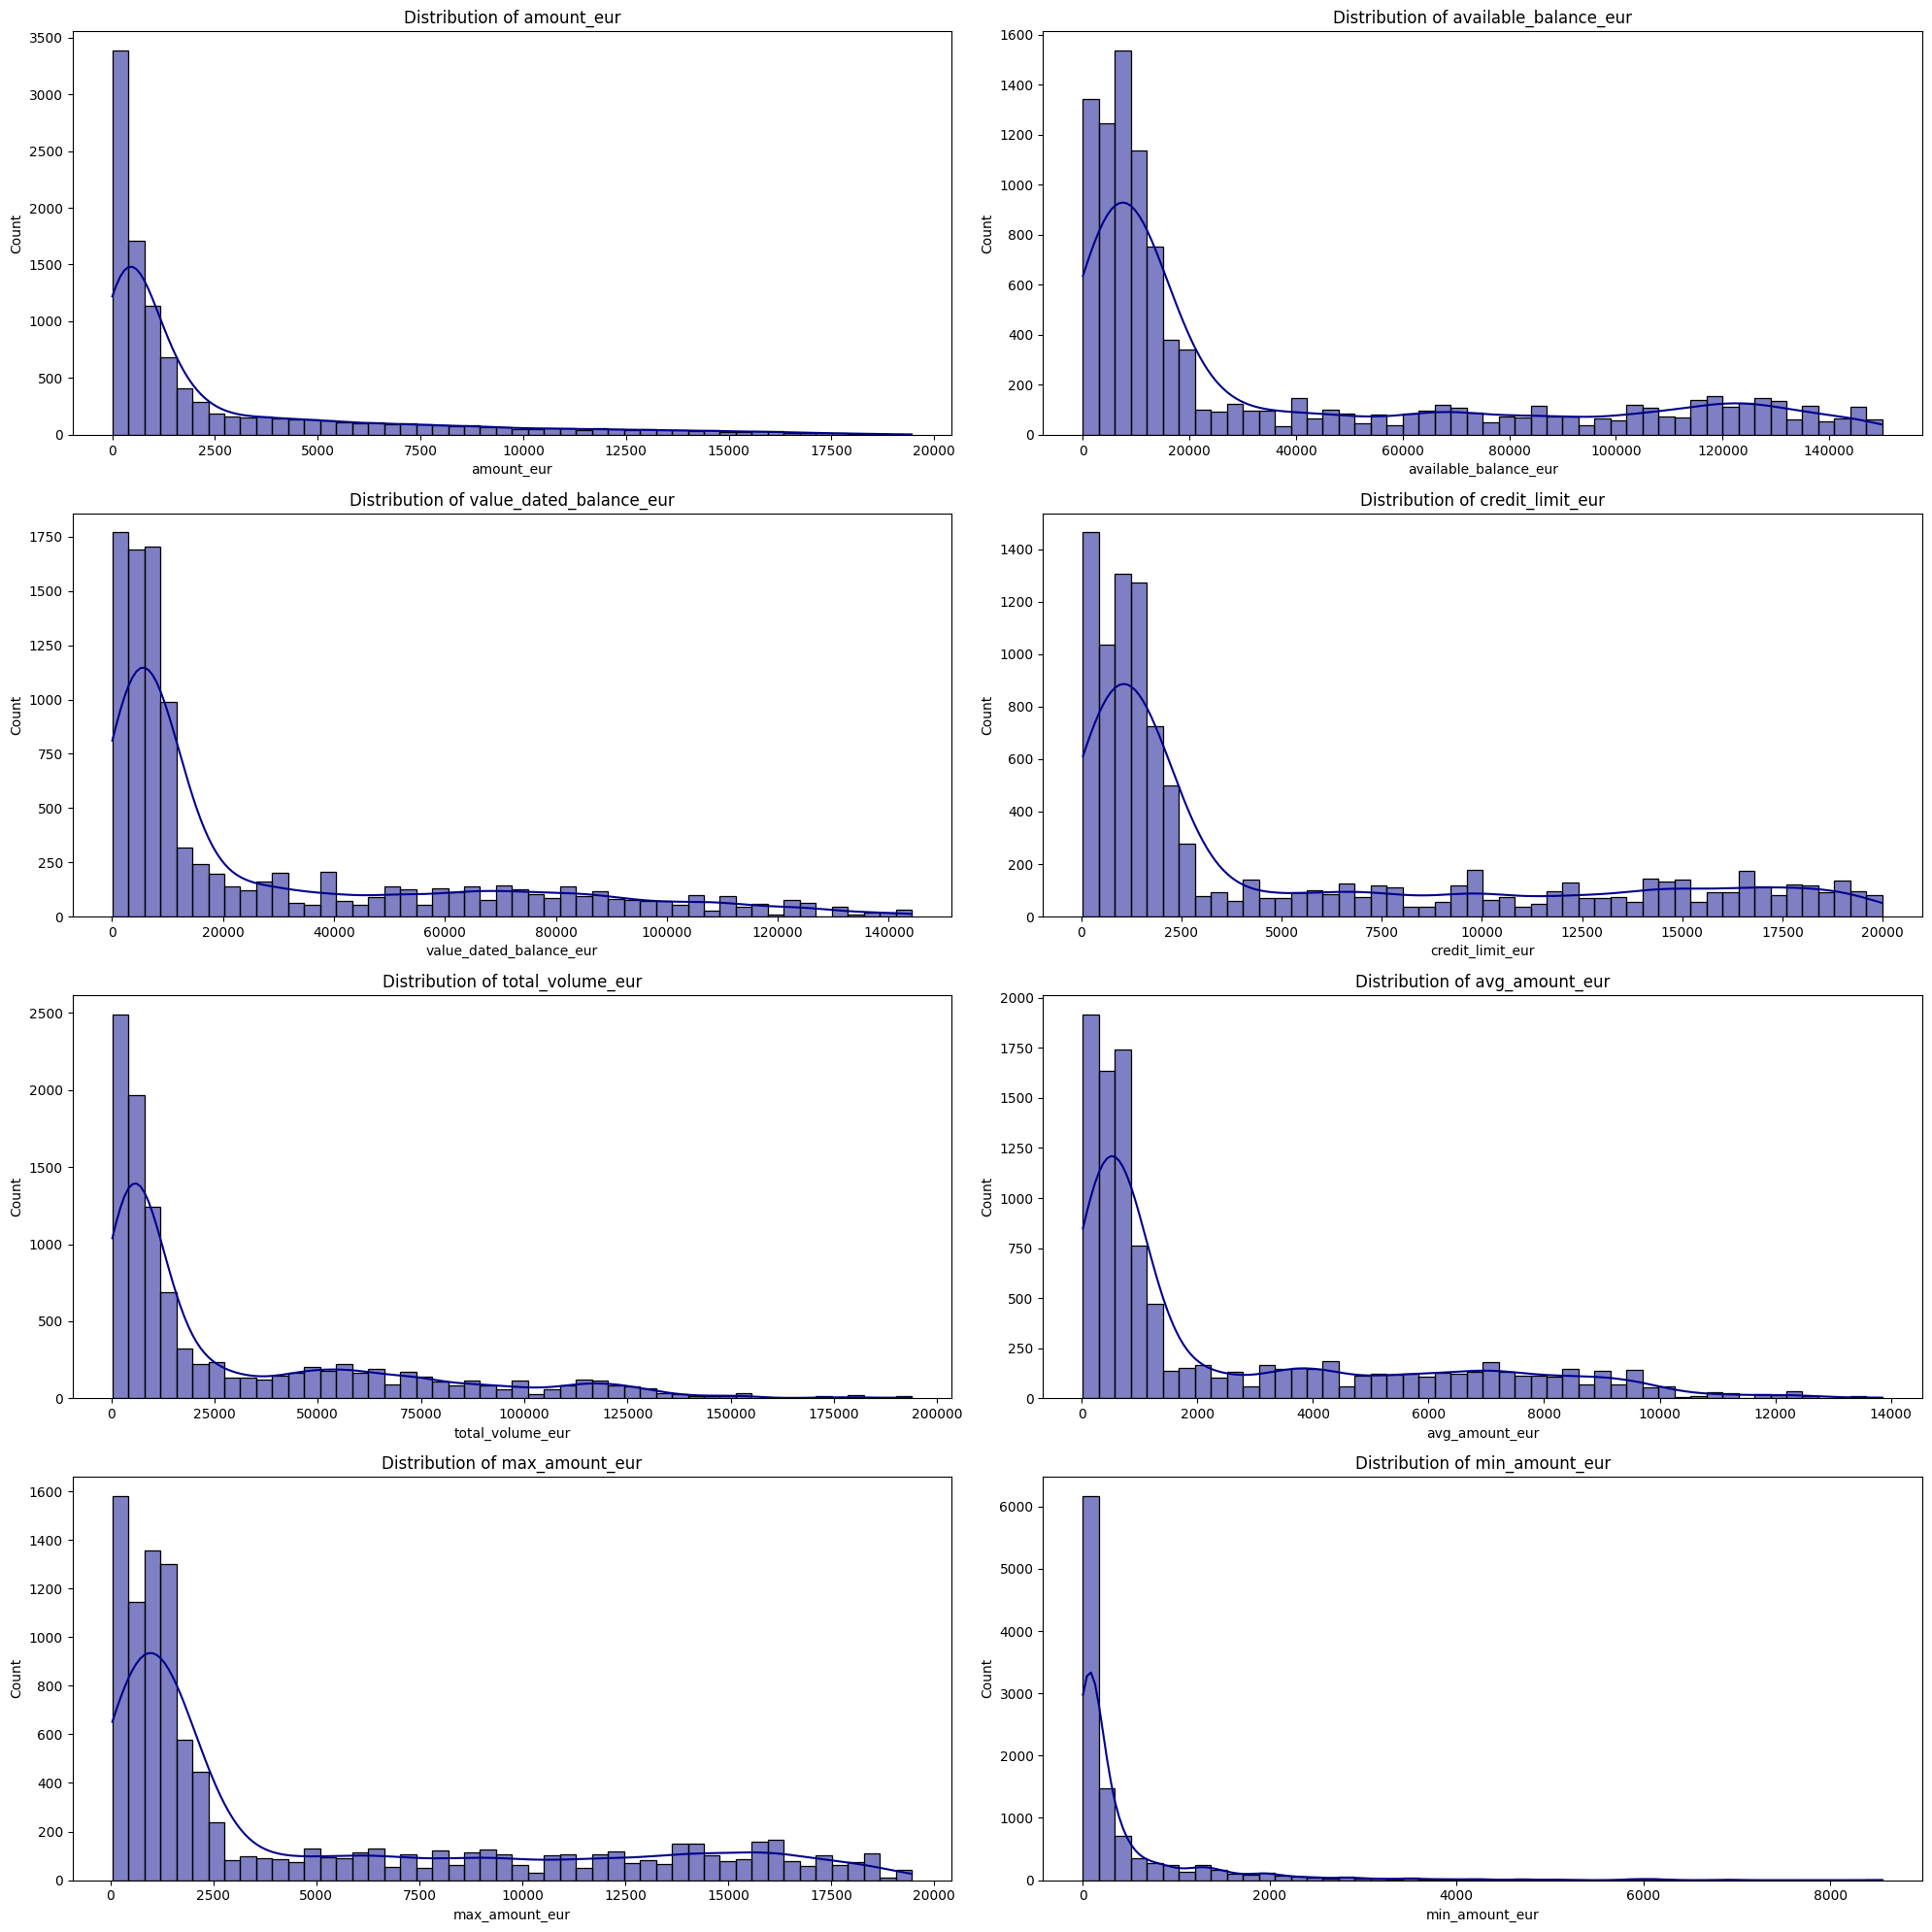

In [20]:
#Let’s explore these Continuous features further.
plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_feature,1):
      df_copy = df.copy()
      plt.subplot(4, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Most of the columns are skewed, so transformation is necessary.

In [21]:
corr_matrix_con = df[continuous_feature].corr()
corr_matrix_con

,amount_eur,available_balance_eur,value_dated_balance_eur,credit_limit_eur,total_volume_eur,avg_amount_eur,max_amount_eur,min_amount_eur
amount_eur,1.000000,0.472689,0.451606,0.788718,0.765276,0.810306,0.791215,0.548389
available_balance_eur,0.472689,1.000000,0.970826,0.592969,0.532068,0.583358,0.588331,0.373292
value_dated_balance_eur,0.451606,0.970826,1.000000,0.567464,0.506132,0.557361,0.562327,0.352716
credit_limit_eur,0.788718,0.592969,0.567464,1.000000,0.921489,0.972493,0.993683,0.590694
total_volume_eur,0.765276,0.532068,0.506132,0.921489,1.000000,0.943994,0.932298,0.554723
avg_amount_eur,0.810306,0.583358,0.557361,0.972493,0.943994,1.000000,0.975676,0.675998
max_amount_eur,0.791215,0.588331,0.562327,0.993683,0.932298,0.975676,1.000000,0.588123
min_amount_eur,0.548389,0.373292,0.352716,0.590694,0.554723,0.675998,0.588123,1.000000


These dependent features are highly correlated; we may want to perform feature selection.

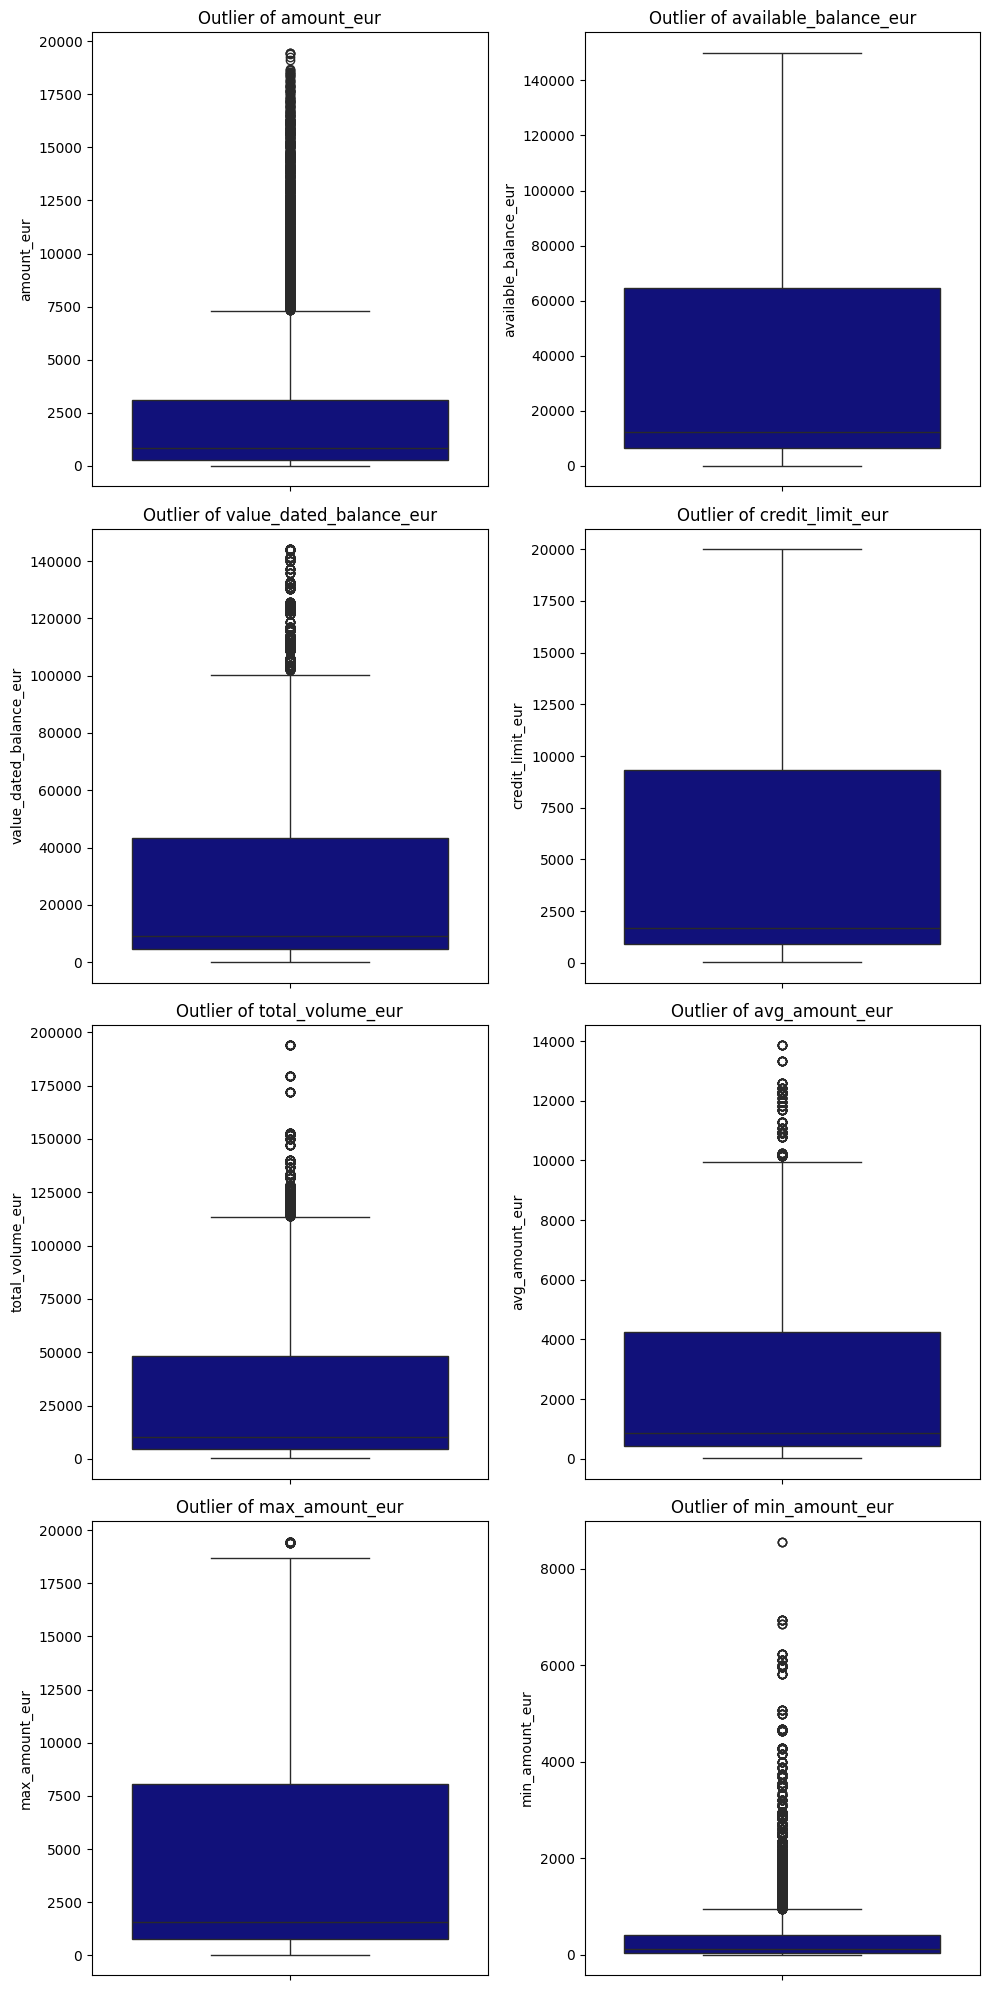

In [22]:
plt.figure(figsize=(10,20))

for i,col in enumerate(continuous_feature,1):
  df_copy = df.copy()
  plt.subplot (4,2,i)
  sns.boxplot(df_copy[col], color='darkblue')
  plt.title(f"Outlier of {col}")

plt.tight_layout()
plt.show()

Most columns have outliers. We need to be mindful of this when handling missing data, especially if there are any continuous features. Additionally, we need to apply some methods to handle these outliers.

**Temporal Variables (Datetime Variables)**

We identify datetime columns from object types, convert them to the correct datetime format, and then transform them into numeric columns.

In [23]:
df.rename(columns= {'latest_transaction_booking_date': 'last_booking_date'}, inplace=True)

In [24]:
from pandas.api.types import is_datetime64_any_dtype

date_col = []

for col in df.columns: 
    if df[col].dtypes == 'O':
      
      try:
         convert = pd.to_datetime(df[col])
         if is_datetime64_any_dtype(convert):
            date_col.append(col)
      except Exception: 
         continue
print (date_col)

['transaction_date', 'value_date', 'payment_date', 'booking_date', 'last_booking_date', 'dob', 'last_transaction_date']


In [25]:
new_date_cols = []
for col in date_col[:]:
    df[col] = pd.to_datetime(df[col])
    df[col + '_day'] = df[col].dt.day
    df[col + '_month'] = df[col].dt.month
    df[col + '_weekday'] = df[col].dt.day_of_week
    new_date_cols.extend([col + '_day', col + '_month', col + '_weekday'])

print(new_date_cols)

['transaction_date_day', 'transaction_date_month', 'transaction_date_weekday', 'value_date_day', 'value_date_month', 'value_date_weekday', 'payment_date_day', 'payment_date_month', 'payment_date_weekday', 'booking_date_day', 'booking_date_month', 'booking_date_weekday', 'last_booking_date_day', 'last_booking_date_month', 'last_booking_date_weekday', 'dob_day', 'dob_month', 'dob_weekday', 'last_transaction_date_day', 'last_transaction_date_month', 'last_transaction_date_weekday']


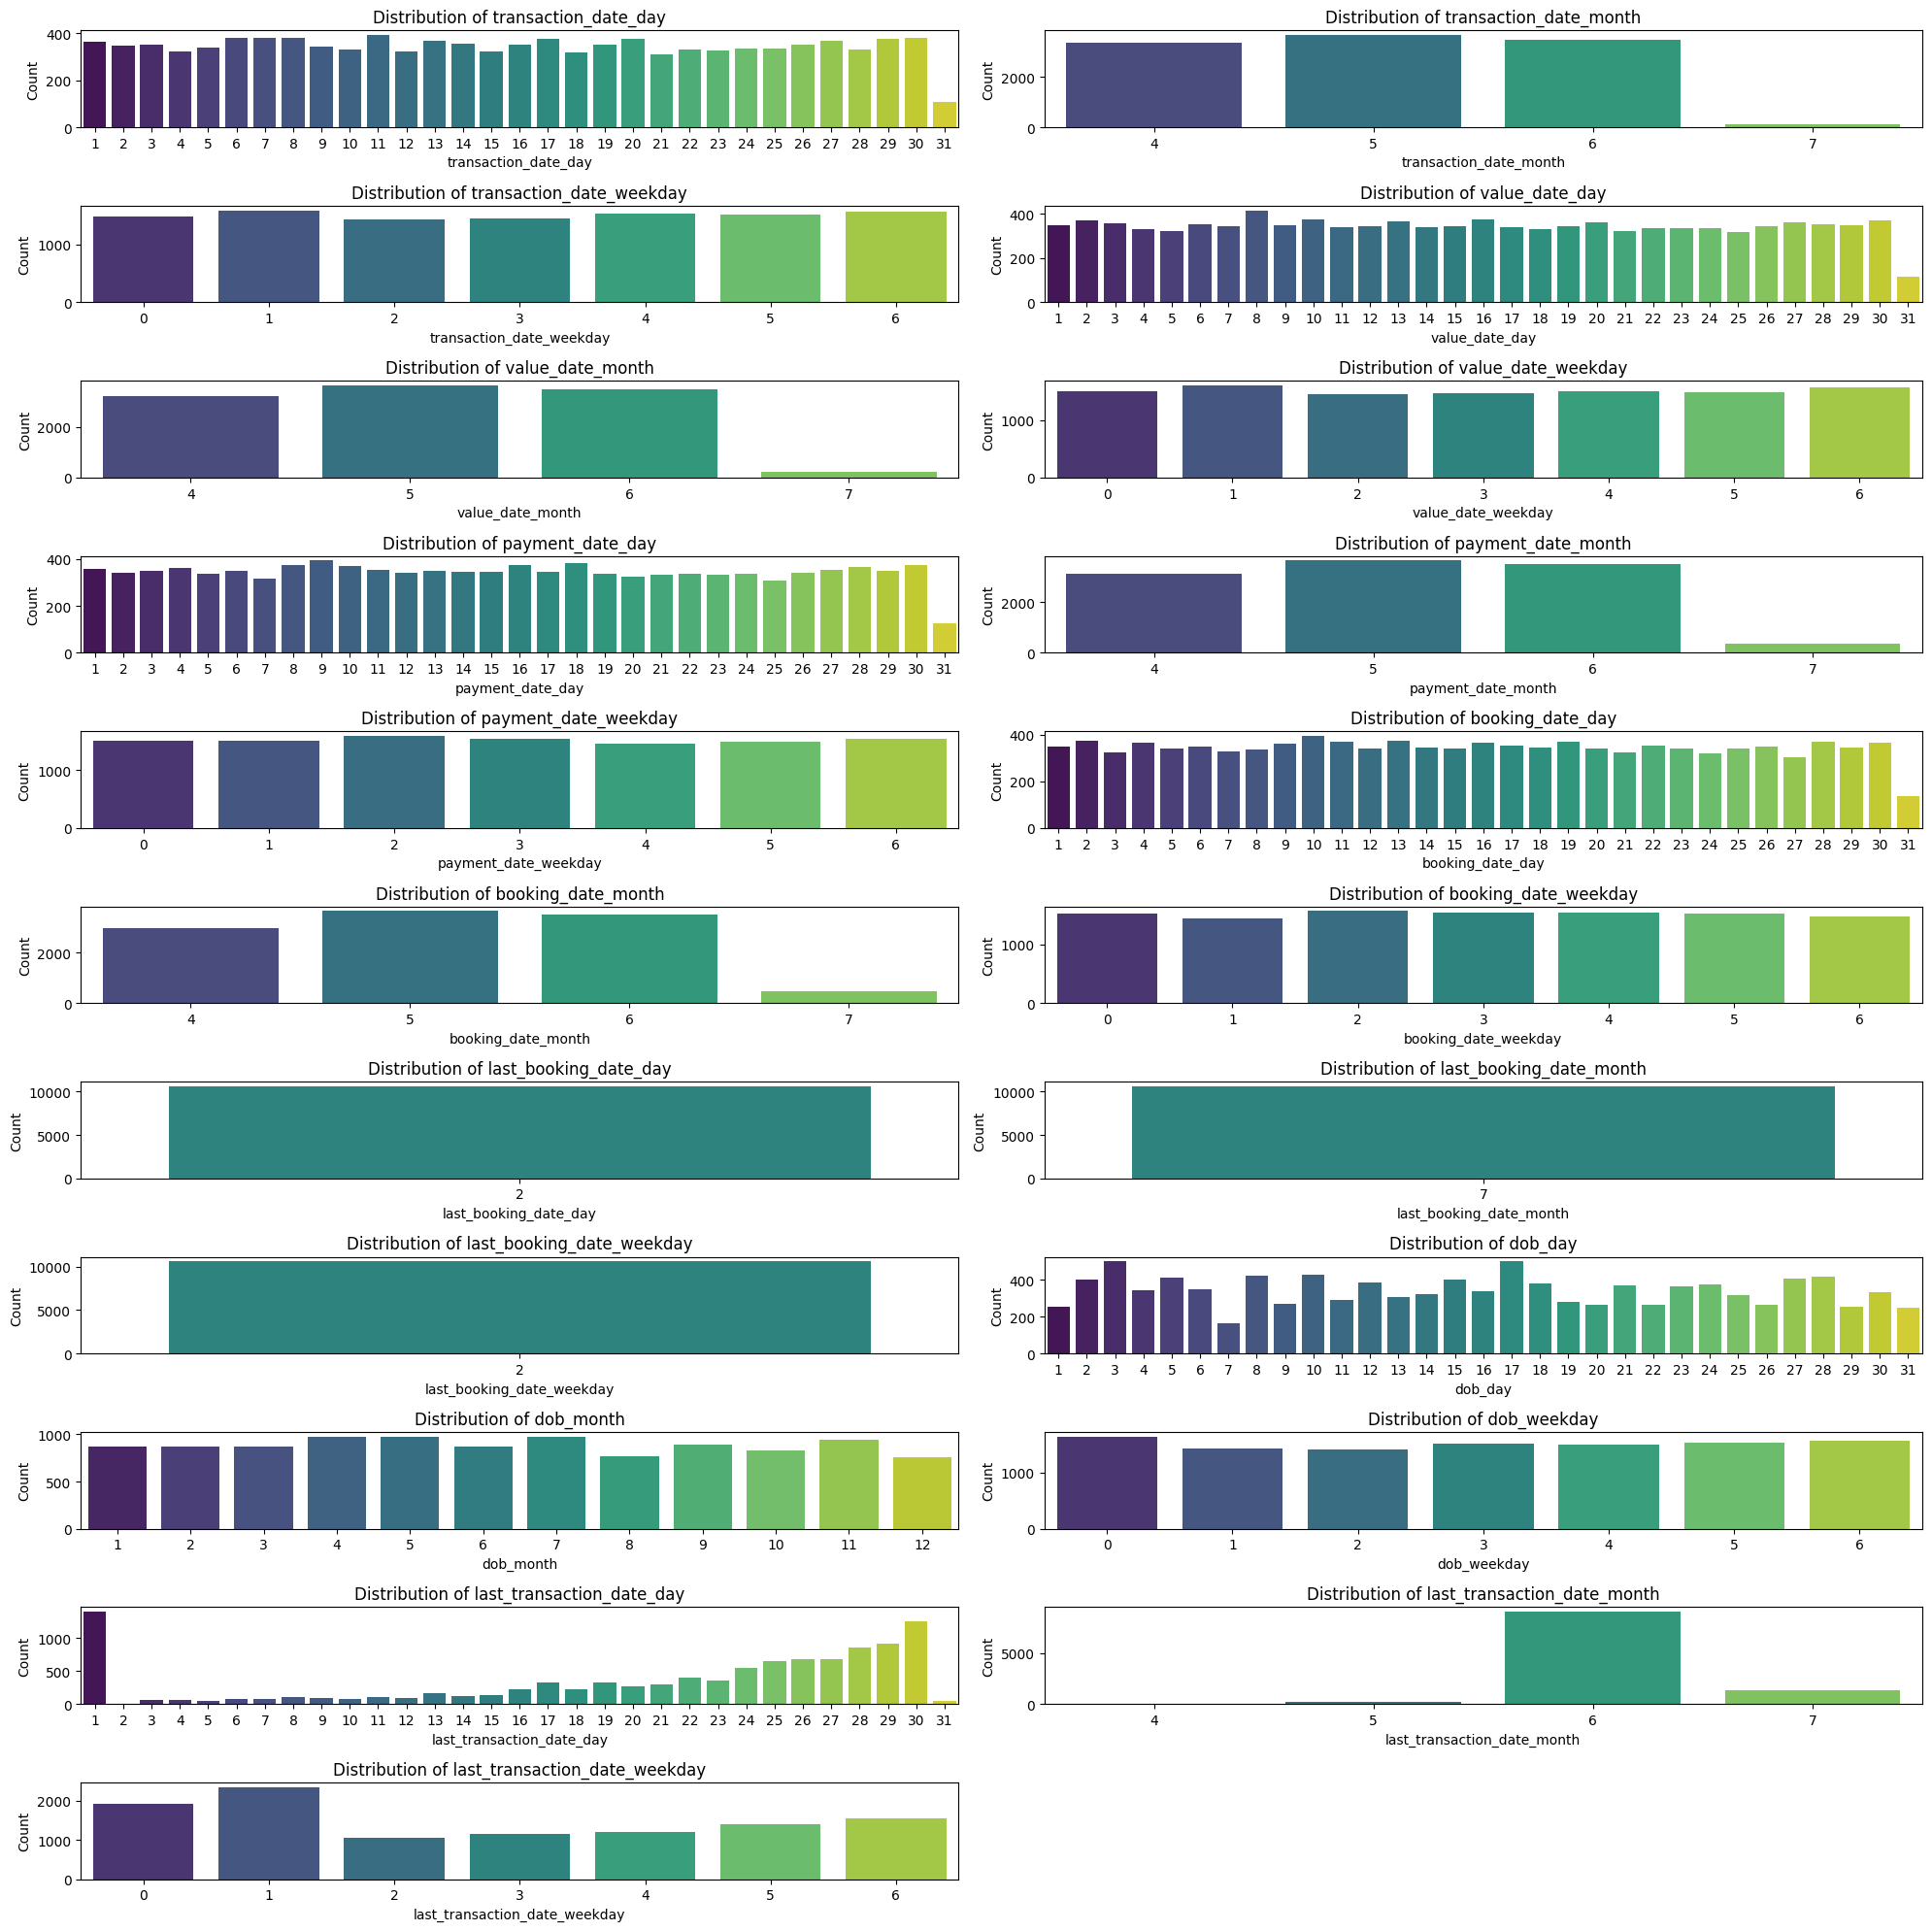

In [27]:
plt.figure(figsize=(20,20))

for i,col in enumerate(new_date_cols,1):
    df_copy = df.copy
    plt.subplot(11,2,i)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Categorical Variables**

In [28]:
categorical_features = df.select_dtypes(include='object').columns.to_list()

In [32]:
#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_features: 
    count_value = df[feature].nunique()
    print (feature,'-', count_value,'categories')

customer_id - 1000 categories
transaction_id - 10609 categories
currency - 4 categories
type_description - 5 categories
transaction_type - 5 categories
narrative - 9809 categories
status_x - 1 categories
counterparty_name - 8372 categories
message - 1 categories
own_message - 1 categories
card_number - 2144 categories
country - 5 categories
account_numbers - 1000 categories
account_name - 998 categories
product - 3 categories
account_type - 2 categories
status_y - 1 categories
registration_number - 1000 categories
residence_country - 5 categories
occupation - 10 categories
gender - 3 categories
bank.name - 1 categories
bank.bic - 1 categories
bank.country - 5 categories


In [30]:
df.to_csv('data/EDA_transaction_monitoring_merged.csv',index=False)